## ЗАДАНИЕ
    Выберите ряд из первого задания.
    Постройте его модель ARIMA.
    Оформите отчёт в Jupyter-ноутбук.
    Дополнительное задание*
    Попробуйте спрогнозировать график классическим ML.


### 1. Подготовка.

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# функция теста на стационарность
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
# графики
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
# def _get_best_model(TS):
#     best_aic = np.inf 
#     best_order = None
#     best_mdl = None

#     for i in range(5):
#         for d in range(5):
#             for j in range(5):
#                 try:
#                     tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
#                         method='mle', trend='nc'
#                     )
#                     tmp_aic = tmp_mdl.aic
#                     if tmp_aic < best_aic:
#                         best_aic = tmp_aic
#                         best_order = (i, d, j)
#                         best_mdl = tmp_mdl
#                 except: continue
#     print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
#     return best_aic, best_order, best_mdl

In [5]:
# Экспериментровал с двумя рядами, но при использовании средних температур график на выходе получаеется более наглядным, поэтому решил остановится на нём
# series = pd.read_csv("../HW_1_Временные_ряды_общая_теория/Series/international-airline-passengers.csv")['Count']
series = pd.read_csv("../HW_1_Временные_ряды_общая_теория/Series/mean-monthly-air-temperature-deg.csv")['Deg']

#### 2. Работа с рядом.

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


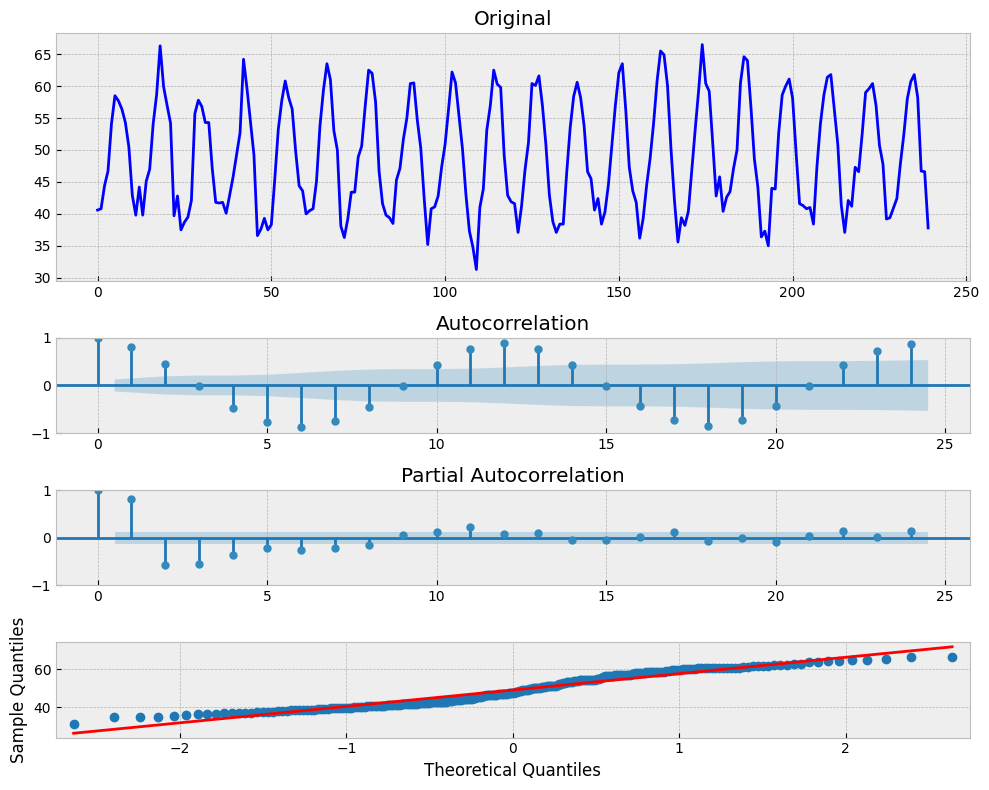

In [6]:
tsplot(series)

##### В ряде присутствуют тренд, сезонность и меняющаяся дисперсия.

Results of Dickey-Fuller Test:
Test Statistic                -7.999033e+00
p-value                        2.361164e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


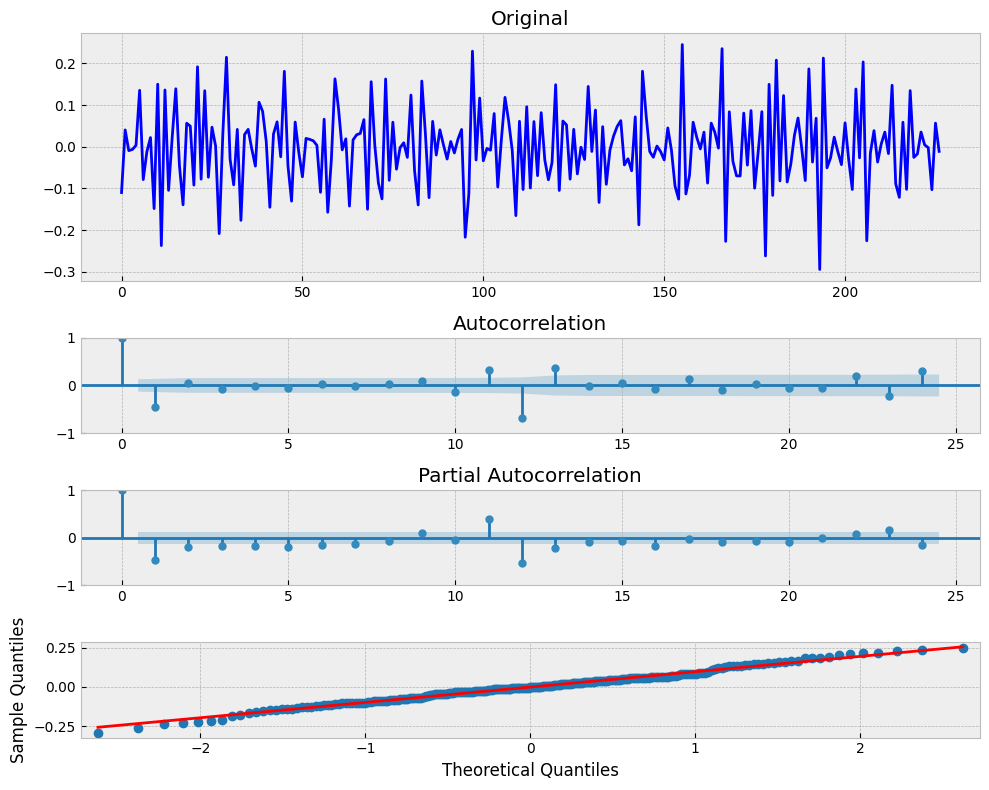

In [7]:
# применяю к ряду преобразования и смотрю, что получилось
series_mod = boxcox(series, 0) # Бокс-Кокс
series_mod = series_mod[1:] - series_mod[:-1] # дифференцирование
series_mod = series_mod[12:] - series_mod[:-12] # сезонность
tsplot(series_mod)

##### Сезонность убрана, ряд стационарный.

##### Применяю ARIMA.
##### Т.к. с момента записи лекций библиотека была изменена и прошлый код не работает, пришлось немного поколдовать.
##### Загружаю отдельный класс для модели и меняю fit в соответствии с документацией.

In [8]:
# Загружаю класс для модели.
from statsmodels.tsa.arima.model import ARIMA
# Т.к. с графиком предсказаний тоже возникли проблемы, импортирую отдельно и его
from statsmodels.graphics.tsaplots import plot_predict
# Много ругается, поэтому убираю предупреждения.
import warnings
warnings.filterwarnings('ignore')

In [9]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in tqdm(range(5)):
    for d in tqdm(range(5)):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i,d,j)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

aic: 1136.11352 | order: (3, 0, 2)


In [10]:
# смотрю, что получилось, т.к. помучился, пока разобрался с новой версией библиотеки
best_mdl.resid[0]

-8.423376919670325

Results of Dickey-Fuller Test:
Test Statistic                  -5.625146
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


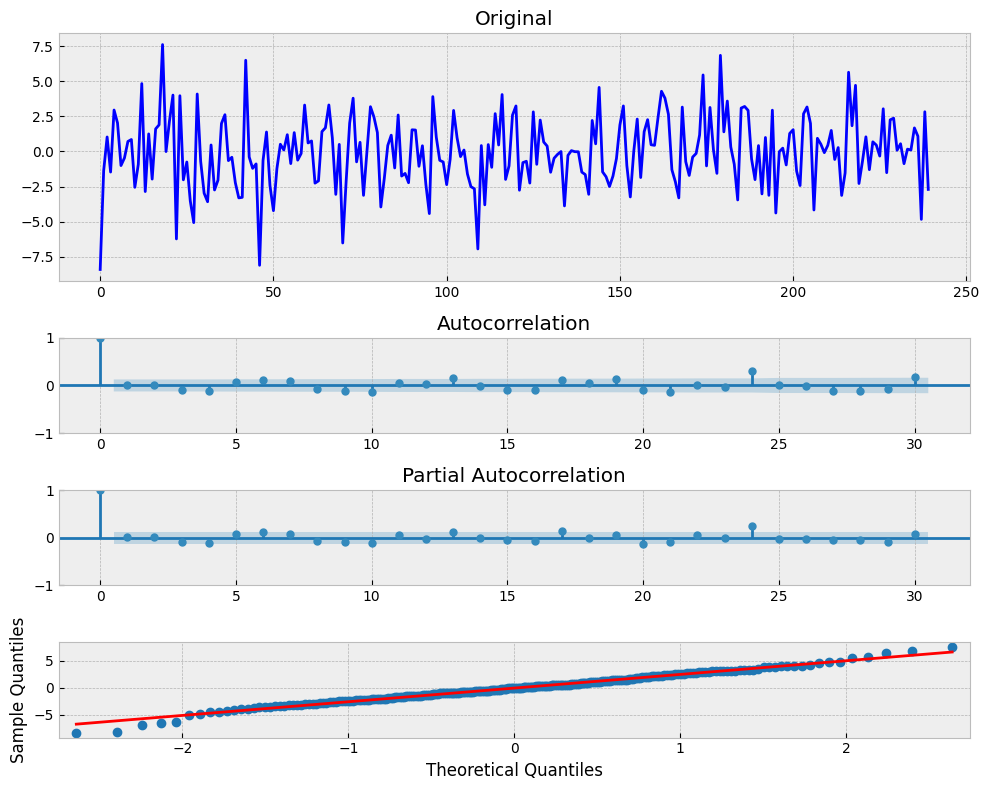

In [11]:
# и ёще раз строю график
tsplot(best_mdl.resid, lags=30)

##### Строю график, снова пришлось помучиться, т.к. ARIMAResults.plot_predict больше не работает, нужно пользоваться plot_predict(ARIMAResults, start=None, end=None, exog=None, dynamic=False, alpha=0.05, plot_insample=True, ax=None).
##### Но на выходе ARIMA отработала неплохо, прогнозный график очень похож на ряд.

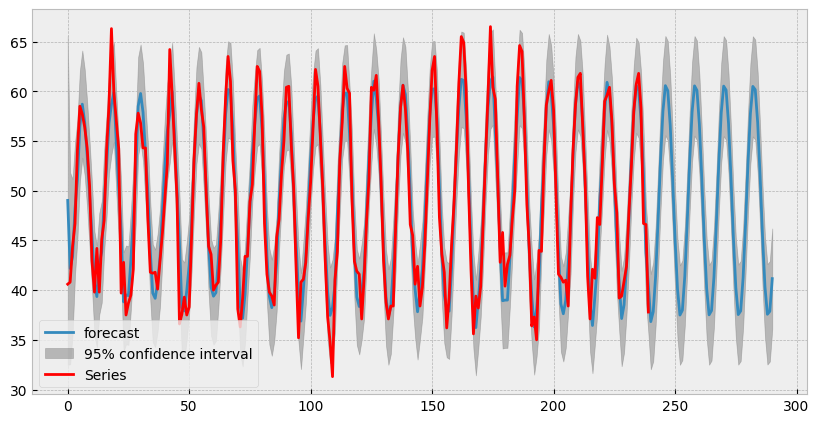

In [12]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10,5))
    ax = plt.axes()
    plot_predict(best_mdl ,0, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

#### 3. Строю предсказание с помощью классического ML.

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
# т.к. во временных рядах тренировочными и тестовыми должны являться определённые отрезки, а не случайная выборка, готовлю функцию для подготовки данных.
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Deg"], axis=1)
    y_train = data.loc[:test_index]["Deg"]
    X_test = data.loc[test_index:].drop(["Deg"], axis=1)
    y_test = data.loc[test_index:]["Deg"]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

##### Ниже строю график предсказания, используя классический ML, т.е. обычную линейную регрессию. Учитывая, что значение score = 0,92 т.е. весьма высокое, можно сделать вывод, что качество предсказания также достаточно неплохое.

score = 	 0.9223020069855584


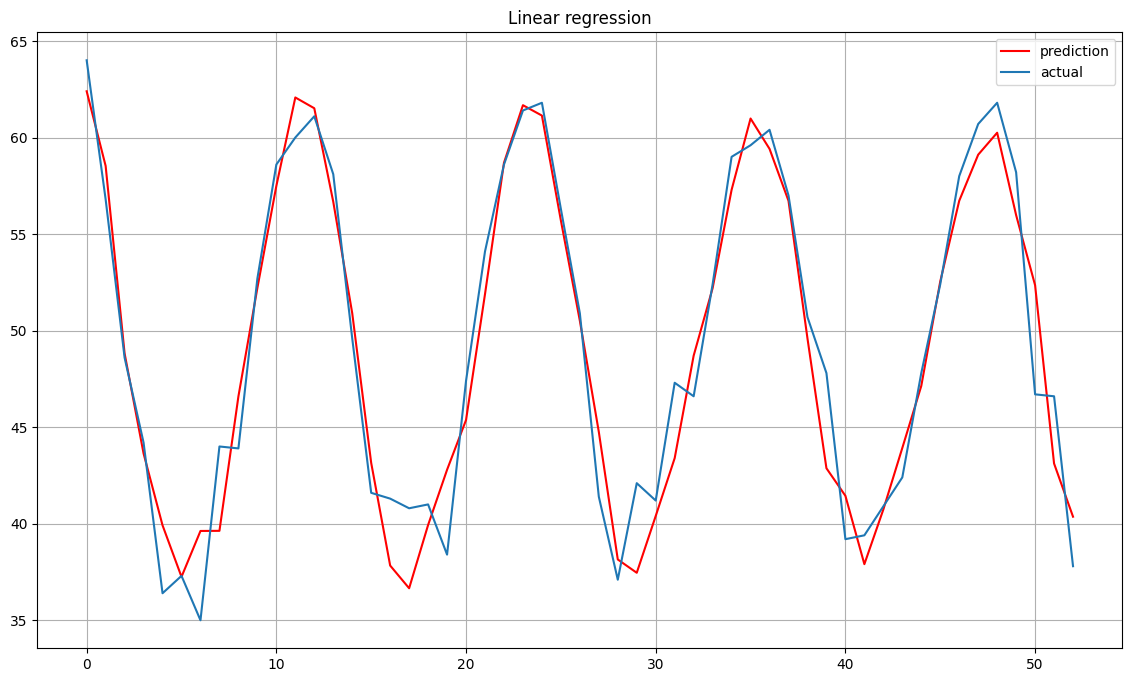

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

print(f"score = \t {lr.score(X_test, y_test)}")